# Introducing PINNs

A Physics-Informed Neural Network (PINN) is a type of neural network that is trained not just on data, but also on physical laws expressed as differential equations. We use a custom loss function and try to minimize it

A typical PINN loss consists of:

**1. Initial Condition Loss**  
This ensures the neural network satisfies the initial conditions of the problem, such as:

$$
u(0) = u_0, \quad \frac{du}{dt}(0) = v_0
$$

**2. Physics Loss (ODE or PDE Residual)**  
This term forces the network output u(t) to satisfy the given physical law. For example, for an ODE like:

$$
\frac{d^2u}{dt^2} + \mu \frac{du}{dt} + k u = 0
$$

we enforce that:

$$
\text{residual} = \frac{d^2u}{dt^2} + \mu \frac{du}{dt} + k u \approx 0
$$

across a range of time points t ϵ [0, T].


Thus, a typical loss function looks like:

$$
\mathcal{L}(\theta) =
\lambda_1 \left(u_{\text{PINN}}(t = 0; \theta) - u_0 \right)^2
+ \lambda_2 \left( \left. \frac{d u_{\text{PINN}}}{dt} \right|_{t = 0; \theta} - v_0 \right)^2
+ \frac{\lambda_3}{N} \sum_{i=1}^{N}
\left( \left[ m \frac{d^2}{dt^2} + \mu \frac{d}{dt} + k \right] u_{\text{PINN}}(t_i; \theta) \right)^2
$$

Here, N is the total no. of points which we want to use to calculate the physics loss.



Below, we try to code a PINN that model the oscillation problem:

### Underdamped Harmonic Oscillator

We consider the second-order ordinary differential equation (ODE) governing a damped harmonic oscillator:

$$
\frac{d^2 u}{dt^2} +  \mu  \frac{du}{dt} + k u = 0
$$

with the following initial conditions:

$$
u(0) = 1, \quad \frac{du}{dt}(0) = 0
$$

This describes an **underdamped oscillator** when the damping coefficient \mu is small relative to the natural frequency.

###  Analytical Solution

For the underdamped case  $$\mu < 2 \sqrt{k}$$ the analytical solution is:

$$
u(t) = 2A e^{- δ t} \cos(\phi + \omega t)
$$

where:

- \$ δ = \frac{\mu}{2} \$ is the damping factor
- \$ \omega = \sqrt{ω_0^2 - d^2} \$ is the damped angular frequency
- \$ \phi = \tan^{-1}\left(-\frac{\delta}{\omega}\right) \$
- \$ A = \frac{1}{2 \omega \cos(\phi)} \$

###  Parameter Values Used

We use the following values in our implementation:

- Damping factor: \$ \delta = 2 \$
- Natural angular frequency: \$ \omega_0 = 20 \$

These values ensure an underdamped system (since \$ \mu^2 < 4k \)$, producing decaying oscillations.




In [1]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def exact_soln(delta, omega, t):      # we define the know exact solution for the problem we wish to model
  omega = np.sqrt(omega**2 - delta**2)
  phi = np.arctan(-delta / omega)
  A = 1 / (2 * np.cos(phi))
  cos = torch.cos(phi + omega * t)
  exp = torch.exp(-delta * t)
  u = exp * 2 * A * cos
  return u

class my_nn(nn.Module):     # defining our neural network
  def __init__(self, n_in_neurons, n_out_neurons, n_hidden_neurons, n_hidden_layers):
    super().__init__()
    activation = nn.Tanh

    # the first layer that takes in the inputs
    self.in_layer = nn.Sequential(
        nn.Linear(n_in_neurons, n_hidden_neurons),
        activation()
    )

    # hidden layers
    self.hidden_layers = nn.Sequential(*[
        nn.Sequential(
            nn.Linear(n_hidden_neurons, n_hidden_neurons),
            activation()
        )
        for _ in range(n_hidden_layers)
    ]
    )
    # layer that gives the output
    self.out_layer = nn.Linear(n_hidden_neurons, n_out_neurons)

  def forward(self, x):     # forward pass
    x = self.in_layer(x)
    x = self.hidden_layers(x)
    x = self.out_layer(x)
    return x

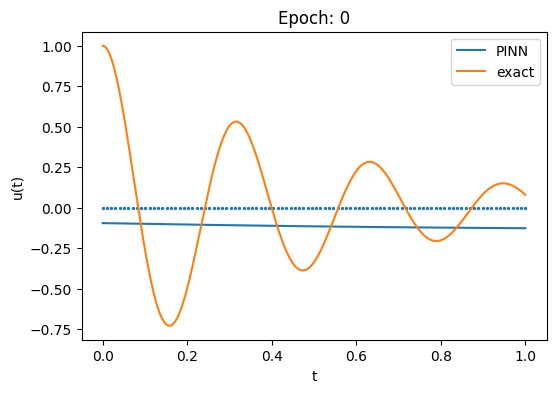

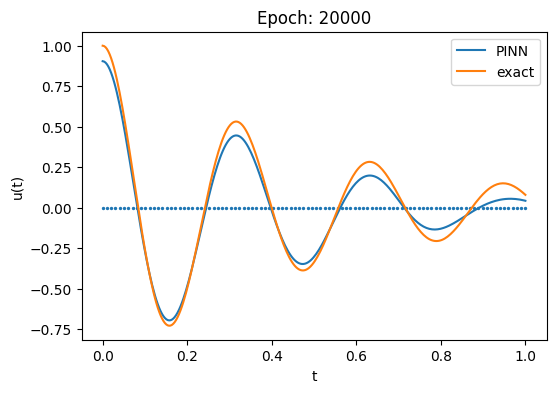

In [17]:
torch.manual_seed(123)

pinn = my_nn(1,1,32,3)    # initializing out neural network

t_initial_conditions = torch.tensor(0.).view(-1,1).requires_grad_(True)     # time vector for the initial conditions available

t_physics_loss = torch.linspace(0,1,100).view(-1,1).requires_grad_(True)    # time vector to calculate the physics loss

delta, omega = 2, 20
mu, k = 2*delta, omega**2
t_test = torch.linspace(0,1,300).view(-1,1)     # to compare results at the end
u_exact = exact_soln(delta, omega, t_test)      # exact solution
optimizer = torch.optim.Adam(pinn.parameters(), lr=1e-3)    # we use the Adam optimizer
for epoch in range(20001):
  optimizer.zero_grad()

  lambda1, lambda2, lambda3 = 1.0, 1e-1, 1e-3     # weights for individual losses (had to be tuned)

  # make prediction at initial conditions and calculate loss1
  u_initial_conditions = pinn(t_initial_conditions)
  loss1 = (torch.squeeze(u_initial_conditions) - 1)**2

  # calculate gradient by the model at initial conditions and calculate loss2
  dudt = torch.autograd.grad(u_initial_conditions, t_initial_conditions, torch.ones_like(u_initial_conditions), create_graph=True)[0]
  loss2 = (torch.squeeze(dudt) - 0)**2

  # make prediction at physics loss points, calculate single and double derivatives and calculate loss3 (differential equation loss)
  u_physics_loss = pinn(t_physics_loss)
  dudt = torch.autograd.grad(u_physics_loss, t_physics_loss, torch.ones_like(u_physics_loss), create_graph=True)[0]
  d2udt2 = torch.autograd.grad(dudt, t_physics_loss, torch.ones_like(dudt), create_graph=True)[0]
  loss3 = torch.mean(((d2udt2) + mu*dudt + k*u_physics_loss)**2)

  # backpropagate and update the parameters
  loss = lambda1*loss1 + lambda2*loss2 + lambda3*loss3
  loss.backward()
  optimizer.step()

  # plotting to compare results
  if not epoch % 20000:
    u_test = pinn(t_test).detach()
    plt.figure(figsize=(6,4))
    plt.scatter(t_physics_loss.detach()[:,0], torch.zeros_like(u_physics_loss)[:,0], s=2)
    plt.plot(t_test.detach()[:,0], u_test.detach()[:,0], label='PINN')
    plt.plot(t_test.detach()[:,0], u_exact.detach()[:,0], label='exact')
    plt.xlabel('t')
    plt.ylabel('u(t)')
    plt.title(f'Epoch: {epoch}')
    plt.legend()
    plt.show()



We can improve the result by properly tuning the hyperparameters lambda1, lambda2 and lambda3, and also by changing the number of hidden layers, neurons per layers, etc.